# Face Generation

In this project, we'll define and train a DCGAN on a dataset of faces. Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible.

The project will be broken down into a series of tasks. At the end of the notebook, we'll be able to visualize the results of the trained Generator to see how it performs.

### Get the Data

We'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks.

### Pre-processed Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> The data is available [here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that we'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, we are left with a directory of data `processed_celeba_small/`

In [1]:
# can comment out after executing
# !unzip processed_celeba_small.zip

In [2]:
data_dir = './processed-celeba-small'

import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since the task is to generate faces, we won't need the annotations. These are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

* Images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* The function should return a DataLoader that shuffles and batches these Tensor images.

In [3]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [4]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    transform = transforms.Compose([ transforms.Resize(image_size),
                                     transforms.ToTensor()])
    
    # return a dataloader
    dataset = datasets.ImageFolder(data_dir, transform=transform)
    
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return data_loader


## Build a DataLoader

* `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training.

In [5]:
# Define function hyperparameters
batch_size = 64
img_size = 32

celeba_train_loader = get_dataloader(batch_size, img_size, data_dir=data_dir)


To view batch images, we'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below.

C:\Users\User\AppData\Local\Temp\ipykernel_13096\1073742529.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])


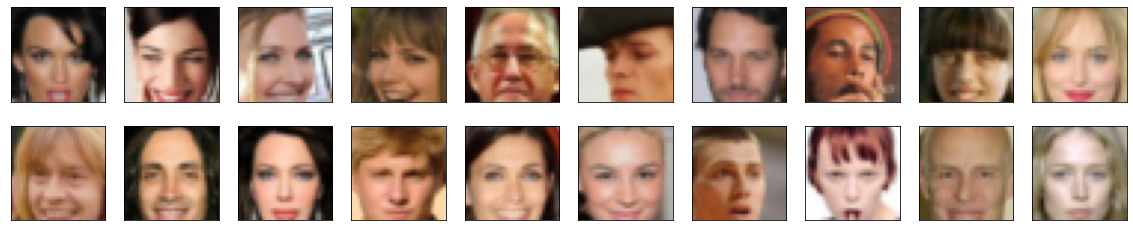

In [6]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Pre-process your image data and scale it to a pixel range of -1 to 1

The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [7]:
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min_, max_ = feature_range
    # fit into range by multiplying with max-min, then shift it to start with min value
    scaled_x = x * (max_ - min_) + min_
    return scaled_x


In [8]:
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9843)
Max:  tensor(0.8588)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

First task will be to define the discriminator. This is a convolutional classifier without any maxpooling layers.

* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # in_channels, out_channels, kernel_size
        
        # input is 32x32x3
        self.conv1 = nn.Conv2d(3, conv_dim, 4, stride=2, padding=1, bias=False)
        # out: 16x16xconv_dim
        
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, 4, stride=2, padding=1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim*2)
        # out: 8x8xconv_dim*2
        
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, 4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*4)
        # out: 4x4xconv_dim*4
        
        self.fc = nn.Linear(conv_dim*4 * 4*4, 1)
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.batch_norm1(x)
        
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.batch_norm2(x)
        
        # flatten x
        x = torch.flatten(x, start_dim=1)
        
        x = self.fc(x)
        
        return x

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # define layers
        # try to adjust parameters as if G is inverse of D
        # output of D: 4x4xconv_dim*4
        
        self.fc = nn.Linear(z_size, 4*4 * conv_dim*4)
        
        self.t_conv1 = nn.ConvTranspose2d(conv_dim*4, conv_dim*2, 4, stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(conv_dim*2)
        
        self.t_conv2 = nn.ConvTranspose2d(conv_dim*2, conv_dim, 4, stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(conv_dim)
        
        self.t_conv3 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1)
        
        

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        x = self.fc(x)
        
        # reshape for conv layer
        x = torch.reshape(x, (-1, self.conv_dim*4, 4, 4)) # batch_size, 4x4xconv_dim
        
        x = F.relu(self.t_conv1(x))
        x = self.batch_norm1(x)
        
        x = F.relu(self.t_conv2(x))
        x = self.batch_norm2(x)
        
        x = self.t_conv3(x)
        
        # apply tanh
        x = torch.tanh(x)
        
        return x

Tests Passed


## Initialize the weights of your networks

To help models converge, from the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf):
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [12]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    # Apply initial weights to convolutional and linear layers
    if classname in ['Linear', 'Conv2d', 'ConvTranspose2d']:
        m.weight.data.normal_(0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0.)
            

## Build complete network

In [13]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Define model hyperparameters

In [14]:
# Define model hyperparams
d_conv_dim = 128
g_conv_dim = 128
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=8192, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (t_conv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_c

### Training on GPU

In [15]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

In [16]:
def real_loss(D_out, real=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.shape[0]
    labels = torch.ones(batch_size)
    if train_on_gpu:
        labels = labels.to('cuda')
    if real:   # smooth
        labels *= 0.9
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.shape[0]
    labels = torch.zeros(batch_size)
    if train_on_gpu:
        labels = labels.to('cuda')
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

In [17]:
import torch.optim as optim

lr = 0.0002
# Form optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(), lr=lr)
g_optimizer = optim.Adam(G.parameters(), lr=lr)

---
## Training

Training will involve alternating between training the discriminator and the generator. 

In [18]:
def train(D, G, n_epochs, print_every=100):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            # ===============================================
            #         TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            
            # clear D grad
            d_optimizer.zero_grad()
            
            if train_on_gpu:
                real_images = real_images.cuda()
            
            # feedforward real images
            # get real images loss
            real_outputs = D(real_images)
            d_real_loss = real_loss(real_outputs)
            
            
            # generate images
            # get latent z loss
            latent_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            # convert to tensor
            latent_z = torch.Tensor(latent_z)
            if train_on_gpu:
                latent_z = latent_z.cuda()
            G_images = G(latent_z)
            G_outputs = D(G_images)
            d_latent_loss = fake_loss(G_outputs)
            
            
            # calculate loss
            # backward pass, calc gradients
            # update weights(optimize)
            d_loss = d_real_loss + d_latent_loss
            d_loss.backward()
            d_optimizer.step()
            
            # 2. Train the generator with an adversarial loss
            
            # clear G grad
            g_optimizer.zero_grad()
            
            
            # feedforward generate images
            latent_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            # convert to tensor
            latent_z = torch.Tensor(latent_z)
            if train_on_gpu:
                latent_z = latent_z.cuda()
            G_images = G(latent_z)
            G_outputs = D(G_images)
            
            # calculate loss - with flipped labels to trick D
            # backward pass, calc gradients
            # update weights(optimize)
            g_loss = real_loss(G_outputs, real=False)
            g_loss.backward()
            g_optimizer.step()
            
        
            # ===============================================
            #              END OF CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # generate and save sample, fake images
        G.eval() # for generating samples
        with torch.no_grad():
            samples_z = G(fixed_z)
            samples_z = samples_z.detach().cpu()
            samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [19]:
# set number of epochs 
n_epochs = 10

# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   10] | d_loss: 2.0070 | g_loss: 1.5627
Epoch [    1/   10] | d_loss: 0.3756 | g_loss: 9.2942
Epoch [    1/   10] | d_loss: 0.3645 | g_loss: 5.9554
Epoch [    1/   10] | d_loss: 0.3611 | g_loss: 6.0746
Epoch [    1/   10] | d_loss: 0.4131 | g_loss: 4.5515
Epoch [    1/   10] | d_loss: 0.4421 | g_loss: 5.4116
Epoch [    1/   10] | d_loss: 0.4365 | g_loss: 6.6932
Epoch [    1/   10] | d_loss: 0.4648 | g_loss: 4.6309
Epoch [    1/   10] | d_loss: 0.6296 | g_loss: 3.5562
Epoch [    1/   10] | d_loss: 0.4570 | g_loss: 3.3063
Epoch [    1/   10] | d_loss: 0.4855 | g_loss: 4.3544
Epoch [    1/   10] | d_loss: 0.4507 | g_loss: 5.8528
Epoch [    1/   10] | d_loss: 0.4666 | g_loss: 7.8564
Epoch [    1/   10] | d_loss: 0.8857 | g_loss: 3.7292
Epoch [    1/   10] | d_loss: 0.5796 | g_loss: 5.3008
Epoch [    2/   10] | d_loss: 0.5277 | g_loss: 6.0201
Epoch [    2/   10] | d_loss: 0.5675 | g_loss: 3.4847
Epoch [    2/   10] | d_loss: 0.4096 | g_loss: 4.1616
Epoch [    2/   10] | d_loss

## Training loss

Let's plot the training losses for the generator and discriminator, recorded after each epoch.

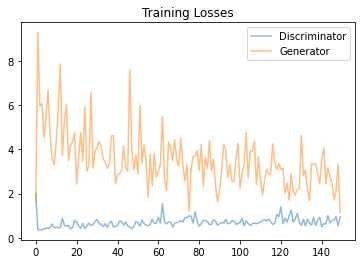

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

In [21]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [22]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

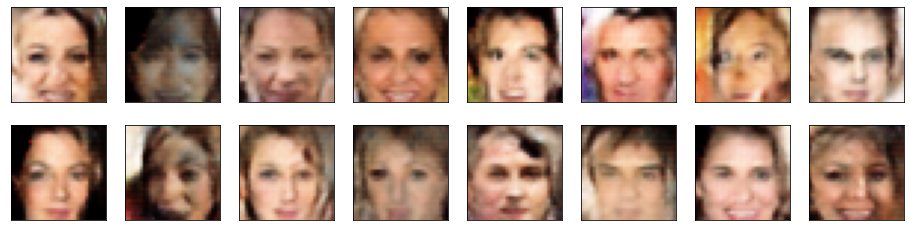

In [23]:
_ = view_samples(-1, samples)

#### Notes about generated samples and how might we can improve this model

1. The generated samples overall looking not very realistic but we can tell that there are images which are appearing as convincing faces. By the generated samples, we can conclude that the data outstandingly matters for GAN models. The faces in this dataset are heavily white, so the learned feature space consists of white people's faces.  
2. We can see from the loss graph that the GAN model is unstable. The plotted loss is spiking frequently. The generator loss is decreasing but the discriminator loss seems to be flattened, which is not desired. We can improve this model by experimenting with different sets of hyperparameters until we get sufficient desired results. DCGAN models are sensitive to hyperparameters and we can tell that the chosen hyperparameters in this task not resulted in realistic outcomes. We can try increasing the filter sizes and the number of layers of both the discriminator and the generator networks to achieve learning feature space more effectively. We can also increase the feature dataset with varying culture's face samples.